# **Support Vector Machines**

## **Intro**


### It is now time to build our model to make predictions on our dataset! First, let's talk a little bit about support vector machines (SVMs). Just as decision trees mirror the human thought surrounding decision making and algorithmic approaches, SVMs work in a similar way by attempting to find the best boundary line that separates data from different classes. 

### Imagine you're in a field, and you see two distinct groups of flowers (daisies and roses) in the field. Your task is to draw a straight line that best separates these two groups. This line should be such that it maximizes its distance from the nearest data point of both groups. This "line" (or more generally in higher dimensions, a hyperplane) is what SVM tries to find. In a 2D space, this is a line, but in more complex datasets with more features, this becomes a plane (or even a hyperplane...) in higher dimensions. The data points that are closest to this line or hyperplane and influence its direction and location are called "support vectors", hence the name of the algorithm. 


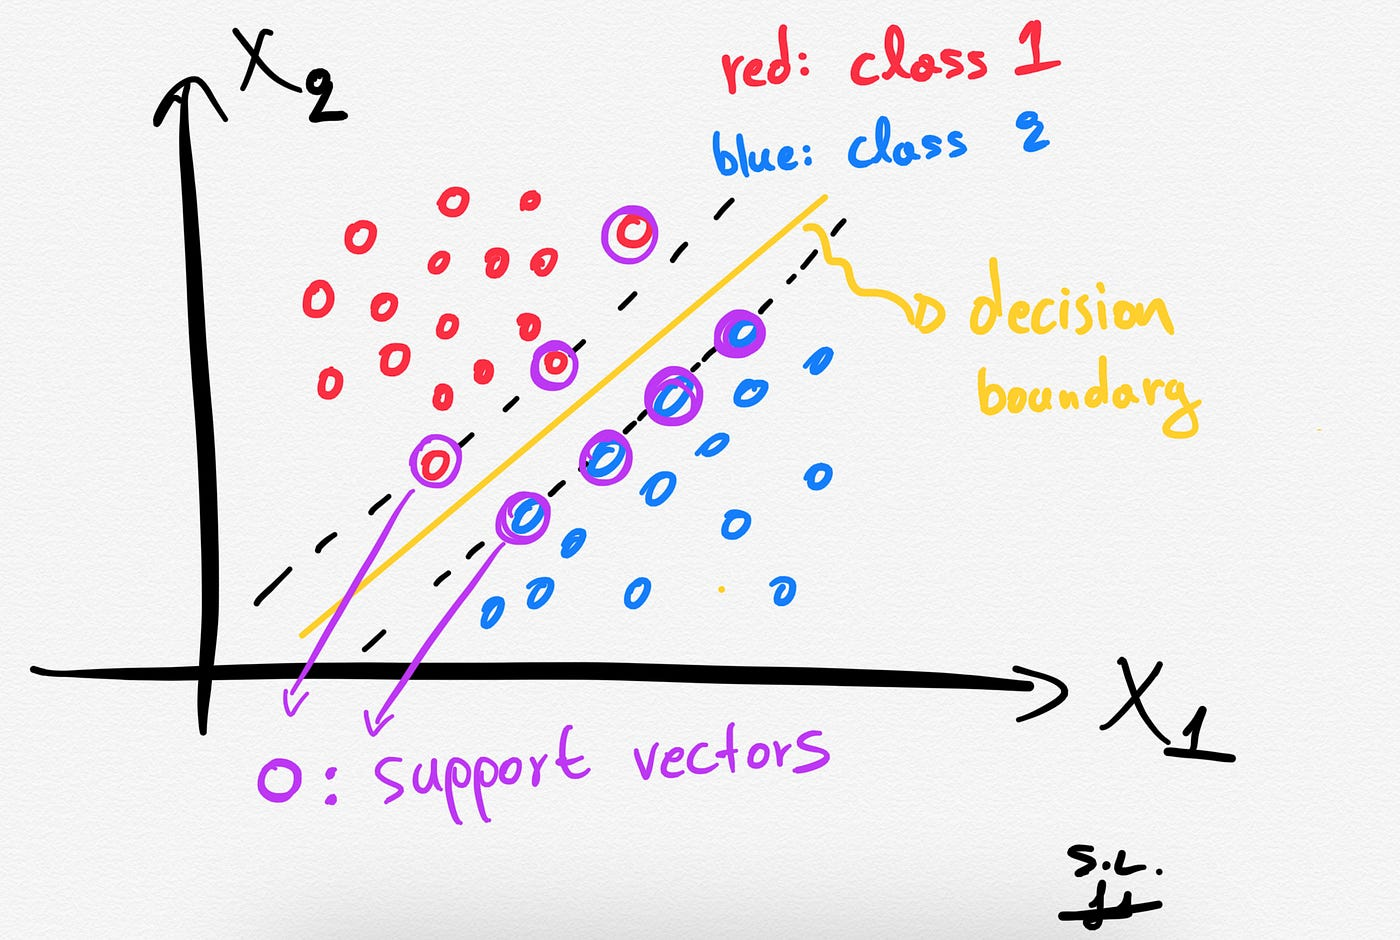

### In the real world, however, not all data is linearly separable, so you can't simply a straight line to separate them. SVMs (fortunately!) are quite capable of dealing with data that is not linearly separable! Instead of trying to draw a line in the original space, SVMs transforms the data into a higher dimension where it becomes linearly separable, finds the separating hyperplane there, and then maps it back to the original space, which might look like a curve or more complex boundary. It does this using something called the kernel trick which we will talk about in some detail later, so don't get worried about it now. Just know that SVM's are general purpose classifiers for many different types of data. While we don't show examples here, it is good for you to know that SVMs can do both classification and regression tasks. When doing classification you build a Support Vector Classifier (which we are doing), and when doing regression you make a Support Vector Regressor. Very creative naming schemes...

### While there is a lot of intense math going on behind the scenes here and words like support vectors, hyperplanes, n-dimensinoal space, etc can get scary, really try and focus on the core principle of what SVMs are doing. They are taking your data as input, learning some important features about it, and doing its best to try and draw a line (or hyperplane) in order to separate your classes to make predictions about future classes (in a support vector classifier). All of the core principles of machine learning still apply. We'll need to train and test to update the weights of the algorithm, ensure there's no data leakage, and measure performance using familiar metrics like precision, recall, and AUROC. With all that being said, lets dive in.


### Import Stuff

In [2]:
# Install and import all the neccessary stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


### Load Data (no preprocessing required)

In [3]:
# Import the dataset
df = pd.read_csv('CKD_Preprocessed.csv')

## **Standardize Features** 

### Lets first take another look at the scale of our data the same way we did last time using histograms. Pay attention to the y axis of these histograms, as the scale of your data is particularly import in SVMs (and we will see why in a bit).

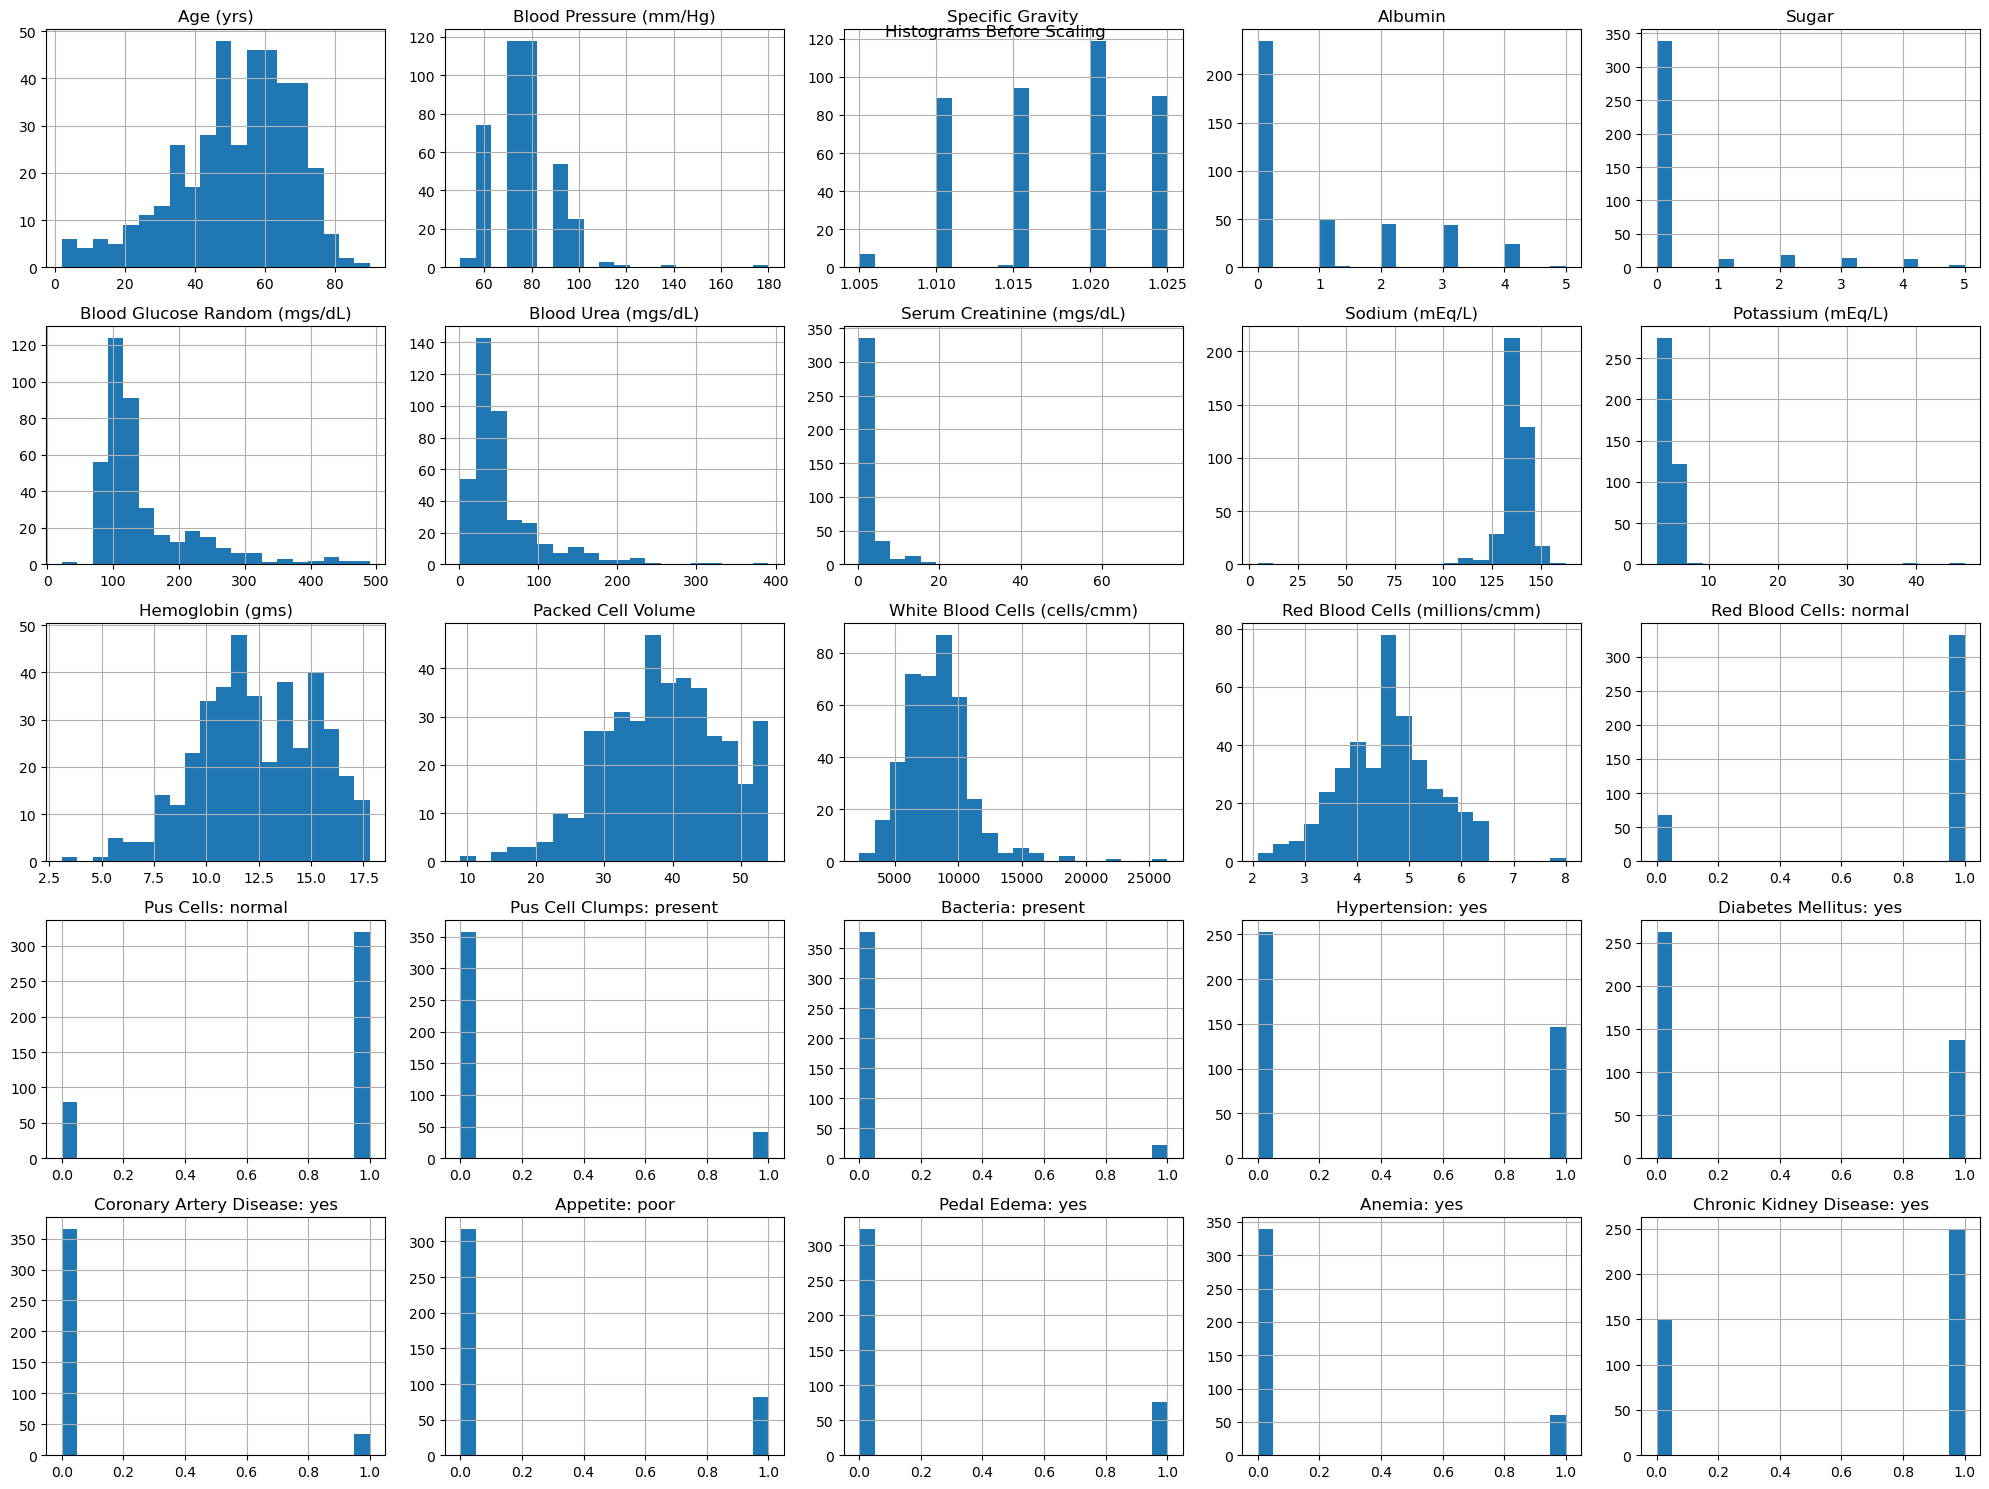

In [4]:
# Select only the columns with datatypes 'float64' and 'int64' from the DataFrame 'df'.
# For these selected columns, create histograms.
# figsize=(20,15) sets the width and height of the entire figure in inches.
# bins=20 means each individual histogram will have 20 bins.
df.select_dtypes(include=['float64', 'int64']).hist(figsize=(20,15), bins=20)

# Adjust the padding between and around the subplots (histograms) for a cleaner look.
plt.tight_layout()

# Set the main title for the entire figure.
plt.suptitle("Histograms Before Scaling")

# Display the figure containing the histograms.
plt.show()


### As you can see, the scale is all over here. We have one hot encoded data which is either 0 or 1, sugar levels which are 0-5, and things like WBCs which go all the way up to 25000. SVMs require data to be on the same scale, because under the hood what is going on is that the `distance` between data points is what is being measured by the SVM and how it will build a hyperplane to eventually do classification. 

### Do not get confused by the notion of distance. In the same way as on a 2D graph you can draw a line between two points and calculate the distance, we can do the same between the distance of our features. Because we have 24 features, however, we are not in 2D, but in 24D. This is a bit of a hairy thing to wrap your brain around, but the underlying math is the same. You might remember from high school math that the euclidean distance between 2 points ($p$ and $q$) in 2D space is represented by

 $d$ = $\sqrt{(p_1-q_1)^2+(p_2-q_2)^2}$
 
 . Easy! This concept easily scales to n dimensional space, and the distance between 2 points in $n$ D space is represented by
 
  $d$ = $\sqrt{(p_1-q_1)^2+(p_2-q_2)^2+...+(p_n-q_n)^2}$
  
  . All we are doing here is accounting for the other dimensions the 2 points exist in. if you have a $3$ d space, each point would need to be defined by its relationship to every dimension (x, y, z in $3$ d). While we dont have easy names for the axes in $24$ d space, the way you calculate the distance is the same as in dimensions we are familiar with.

### Fortunately, we don't have to work any of this math by hand, but this simple example helps explain why the scale is so important. If some of our features live on a scale from 0-1 but some live on the scale of 0-25000, when we try to calculate the distance between these points the binary features will get drowned out due to the massive distances of the other features. 

### We can easily fix this problem and build an SVM for our data using the `StandardScaler` class from scikit-learn (see module 2 notebook 4 for a review), but basically what this is doing is, for every feature, scales it so the average of the data is = 0 and the standard deviation is 1 (this is called z-score standardization). Thus when the SVM tries to calculate the distances between the features to build our classifier everything is now on the same scale, and it can actually work!

## Now we can split the data and actually apply the standardization.

### Small note, the order in which you split the data and then do scaling is very important. If we scale all of the data prior to testing and training, we actually allow the training data to 'see' some of the testing data as the scaling process invovles the mean and standardization of the training data. This constitutes data leakage, and as covered in module 2, is one of the worst sins in machine learning.

### To avoid this, we first split the data and then scale the training data using the `fit_transform` method. The `fit` part learns the statistics (mean and standard deviation) of the training data, and the `transform` part then scales the training data based on these statistics

### The line `X_test_standardized = scaler.transform(X_test)` only applies the transform step using the statistics learned exclusively from the training data. Importantly, the test data is not used to learn any new statistics.

### In this way, the test set remains truly unseen: the transformations applied to it are solely based on the statistics from the training data, ensuring no information from the test set "leaks" into the training process. 

In [5]:
# Split the data into features and target variable
X = df.drop("Chronic Kidney Disease: yes", axis=1)
y = df["Chronic Kidney Disease: yes"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)   # Fit and transform the training data
X_test_standardized = scaler.transform(X_test)         # Only transform the test data


### Now, before we train and test lets just replot the standardized data to make sure we are happy with what we did.

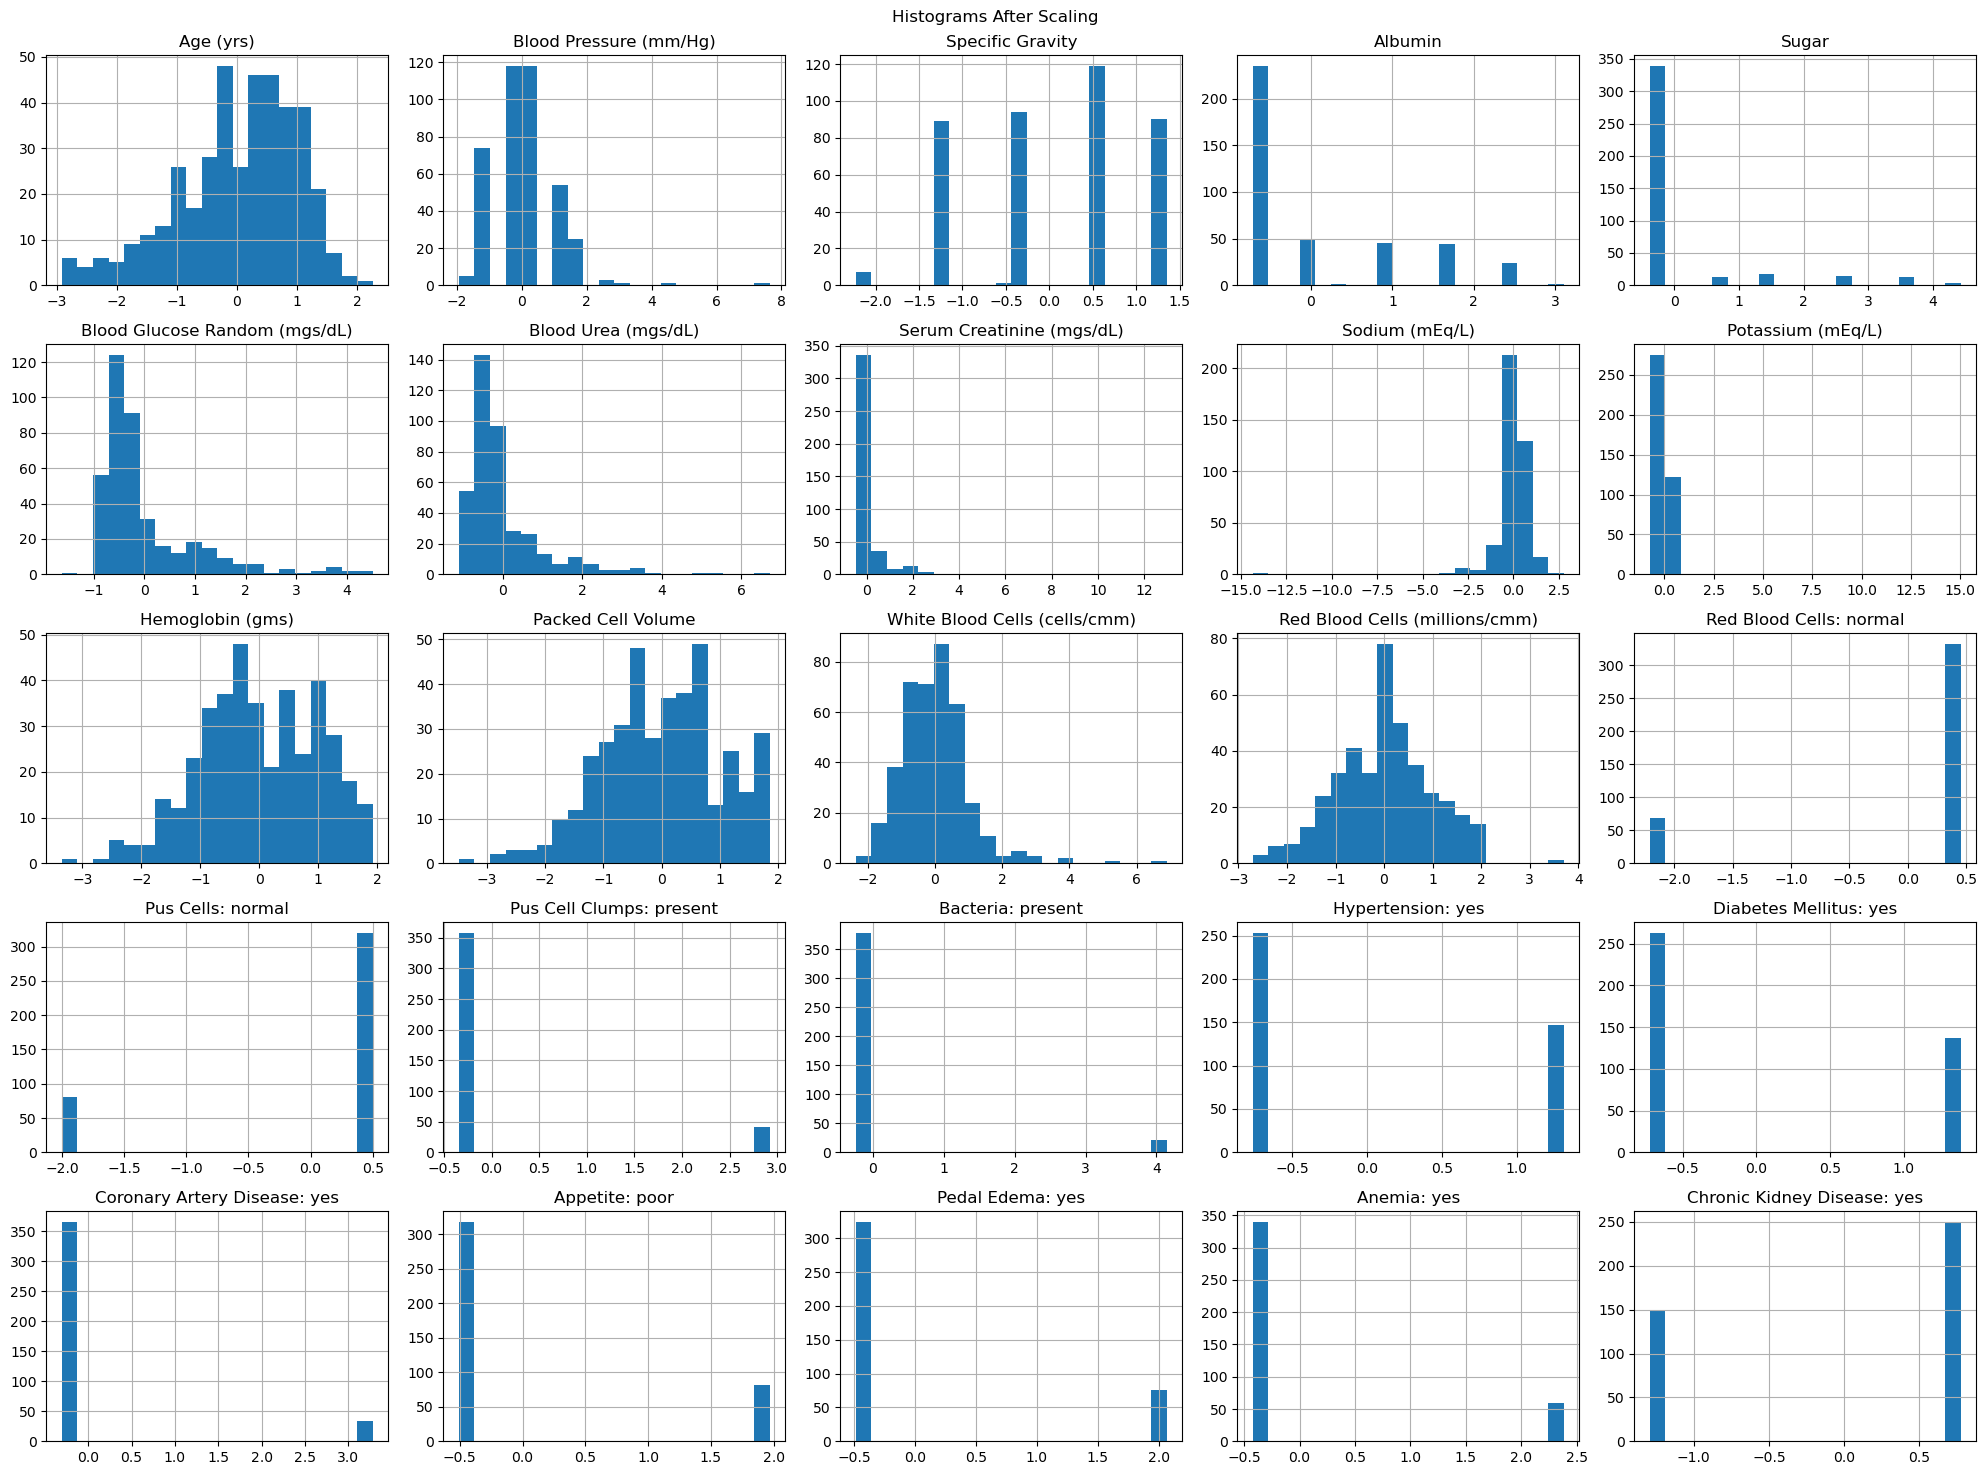

In [6]:
# Apply the StandardScaler to the columns of the dataframe with datatype float64 or int64.
# The 'fit_transform' method first learns the statistics (mean and standard deviation) of the data,
# and then scales the data based on these statistics.
df_standardized = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))

# Convert the standardized data (which is in numpy array format) back to a pandas DataFrame.
# We're using the same column names as the original data for clarity.
df_standardized = pd.DataFrame(df_standardized, columns=df.select_dtypes(include=['float64', 'int64']).columns)

# Plot histograms for each column of the standardized data.
# The figsize argument specifies the width and height of the figure in inches.
# bins=20 means each histogram will have 20 bins.
df_standardized.hist(figsize=(20,15), bins=20)

# Set the main title for all subplots (histograms).
plt.suptitle("Histograms After Scaling")

# Adjust the padding between and around subplots for a cleaner look.
plt.tight_layout()

# Adjust the top padding to ensure the main title doesn't overlap with subplots.
plt.subplots_adjust(top=0.95)

# Display the histograms.
plt.show()


### Looks good! The scaling worked and 0 is now the mean and there is a standard deviation of 1. We can't *really* tell that by eye, to be fair, but what we can see is that the magnitude of the x axis for all the features has been brought within a range that we might expect, and this will allow us to proceed with confidence in building our model. 

## **Train and Test Model**

### Ok! We are now ready to train and test our SVM. There is one thing we want to talk more about prior to doing this, and that is the notion of an SVM Kernel.

### In the context of SVMs, the kernel is a function that calculates a dot product between two input vectors in such a way that it implicitly maps them into a higher-dimensional space. This is helpful because sometimes data that isn't linearly separable in its original space can become linearly separable in a higher-dimensional space. 

### The magic of SVM kernels is that they allow for this higher-dimensional representation without actually having to compute the data in that space, making computations feasible and efficient. 

### In broad, non-mathey strokes, all the kernel is doing is taking the input data, modifying it in some fancy ways, and then using this modified data to actually draw the line of separation. This can be very hard to visualize as it is (literally) multidimensional, but the choice of kernel you use are all dependent on your data and requires experimentation and domain knowledge. 

### We use a linear kernel here, which basically assumes our input data will alrady be pretty close to linearly separable so only a simple linear dot product is taken (this is basically using no kernel). Other types of kernels include polynomial, sigmoid, radial basis function (RBF), and many others, but an in depth discussion of these are well out of the scope of Code Grand Rounds. For now, just know that the kernel is the magic transformer of an SVM that helps in making hard to predict data easier to predict! 

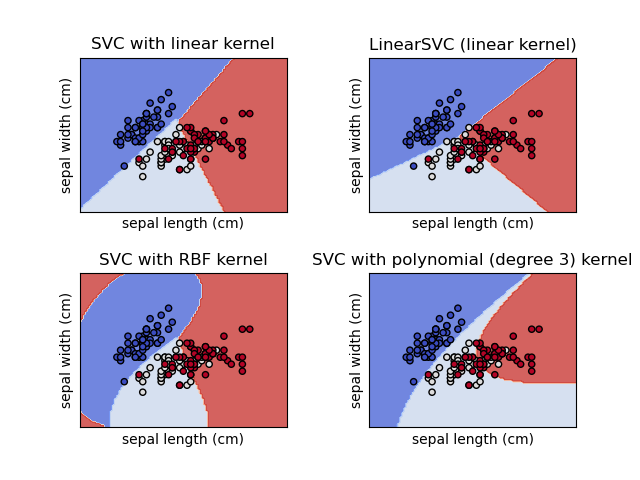

In [7]:
# Train the SVM with a linear kernel
support_vector_machine = SVC(kernel='linear', probability=True)  # Using probability=True to enable the calculation of ROC-AUC
support_vector_machine.fit(X_train_standardized, y_train)

# Predict on the test data
y_pred = support_vector_machine.predict(X_test_standardized)
y_pred_proba = support_vector_machine.predict_proba(X_test_standardized)[:, 1]  # Probabilities for the positive class

# Calculate the AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC: \n", roc_auc)

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


AUC-ROC: 
 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        72
         1.0       1.00      0.98      0.99       128

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



### Now that is a promising outcome. Based on this, we literally made a perfect model. It got every positive and negative case right with perfect precision and recall, and the AUC-ROC was 1 indicating it was a perfect classifier. 

### This could be really great, but whenever you see something like this alarm bells should go off and you should definitely do some more testing to see if it is real, or if you have done something wrong.

### In this case, because we did so well on our test set it looks like the model is either A) Overfitting or B) Suffering from test set leakage. We took pretty great care to avoid leakage earlier, so lets make sure it is not overfitting. It is also possible that this is just a really easy to classify dataset.

### We can start by doing k fold cross validation. This technique first divides the data into 'k' parts (if you have 1000 data points and using 10 fold, each fold will then have 100 data points). the model is trained on k-1 parts (9 if using k=10) and tested on the remaining part. This process is repeated 'k' times, each time with a different test set. If the performance metrics have high variance across the folds, it's an indication that the model might be overfitting to specific subsets of the data. If the average and standard deviation does not show a lot of variance, it strengthens our confidence in the model. 

### This technique can become computationally expensive if you have lots of data (as it trains the model k individual times), but it is a great way to understand if your model will actually perform well on new, unseen data, as you train and test on multiple subsets of your data multiple times. For this reason, a k of 10 is often times better than a k of 3, but the value of k you pick will depend on your project, compututational resources, and domain knowlege. We will use 10 here as it is fast to train on this particular dataset!


In [8]:
from sklearn.model_selection import cross_val_score

# Create a new SVM model
svm_model = SVC(kernel='rbf', probability=True)

# Perform cross-validation: cv defines the k
scores = cross_val_score(svm_model, X_train_standardized, y_train, cv=10, scoring='accuracy')

# Print results
print(f"Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")


[0.95 1.   1.   1.   1.   1.   1.   1.   1.   0.95]
Accuracy: 0.99 (+/- 0.04)


### Pretty cool!  What the results show is that after splitting our data into 10 sets (k=10), training on 9 and testing on 1 (rotating for each iteration), our model achieves an average accuracy of 99% with a standard deviation of +/- 0.04%. This k-fold cross-validation process gives us added confidence that our model's performance is consistent and isn't just a result of a fortunate split of the data.

### Although this is certainly reassuring, there are other advanced techniques and considerations one could explore. The real test for this model would be to evaluate its performance on entirely new, unseen data. If the model's accuracy remains high, that's a robust sign of its effectiveness. However, if we observe a significant drop in performance, it could indicate overfitting. In deep learning scenarios, another useful diagnostic tool to evaluate overfitting is to plot training and validation losses (or accuracies) across epochs to monitor the model's learning trajectory, but this will make more sense soon!

### We will leave all of that to you, however. Good job on making it through the machine learning module! We covered so many concepts at a fast pace, so we applaud you for sticking with it and hope you got a lot out of it. See you in the Intro to AI section!